## 全连接神经网络（多层感知机）

用pytorch加载数据集，用numpy实现前向传播和反向传播

已实现：
- 基础参数: epochs, batch(shuffle), 学习率等；
- 全连接神经网络的结构和参数: 层数, 每层神经元个数, 权重, 偏置；
- 数据集划分：训练集, 验证集, 测试集；
- 模型参数初始化: 权重用Xavier / He初始化; 偏置全0；
- 损失函数: 交叉熵；
- 激活函数: 隐藏层用Sigmoid / ReLU; 输出层用Softmax；
- 优化器: GD, Adam；
- 过程：加载MNIST数据集, 前向传播, 反向传播, 参数更新, 模型的加载和保存等；
- 模式: 仅训练, 仅测试, 训练与测试
- 防止过拟合的方法: 早停法
- 可视化: 训练集损失曲线和验证集准确率变化曲线，每轮结果输出，预测结果与真实标签比较。

未实现：
- 更复杂的模型：卷积等；
- 学习率调度器
- 数据增强，图像增广
- 其它防止过拟合的方法: 批归一化BN, l2正则化, Dropout

In [373]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [374]:
# 加载MNIST数据集，返回训练集，验证集，测试集
def load_mnist_data(data_path, batch_size, val_ratio):

    # 将大小为[28*28]的MNIST灰度图像转换为张量
    transform = transforms.Compose([
        transforms.ToTensor(),      # [28,28] → [1,28,28]，并归一化到 [0,1]
        lambda x: x.view(-1)        # 展平为 [784]
    ])
    
    # 加载训练集和测试集
    full_train_dataset = datasets.MNIST(root=data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=data_path, train=False, download=True, transform=transform)
    
    # 按比例划分训练集和验证集
    val_size = int(len(full_train_dataset) * val_ratio)
    train_size = len(full_train_dataset) - val_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
    
    # mini-batch和每轮epoch随机打乱训练样本
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader


<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([32, 784])
torch.Size([32])
tensor([3, 1, 8, 8, 2, 6, 5, 2, 6, 5])
<class 'numpy.ndarray'>
(32, 784)


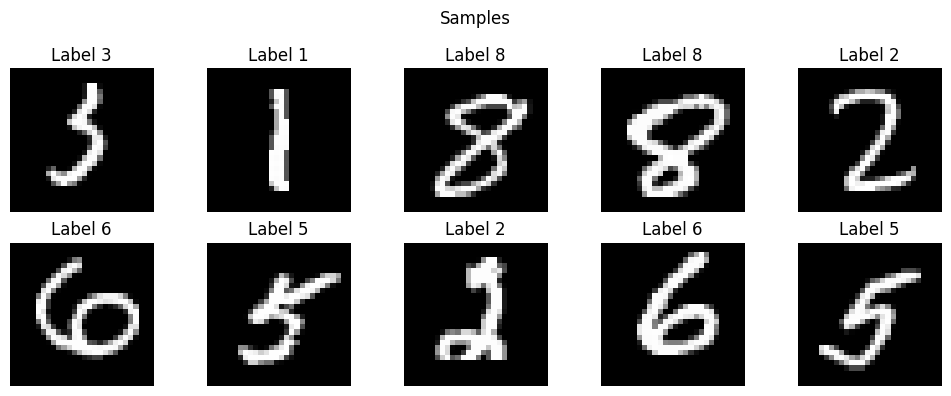

In [375]:
# 可视化样本数据
def visualize_samples():

    # 加载数据集
    train_loader, _, _ = load_mnist_data(data_path='../data', batch_size=32, val_ratio=0.167)
    
    X, y = next(iter(train_loader))
    print(type(X))          # <class 'torch.Tensor'>
    print(type(y))          # <class 'torch.Tensor'>
    print(X.shape)          # torch.Size([batch_size, image_size]) -> (32, 784)
    print(y.shape)          # torch.Size([batch_size]) -> (32,)
    print(y[:10])           # 前10个样本的标签
    print(type(X.numpy()))  # 转为numpy
    print(X.numpy().shape)  # (32, 784)
    
    # 可视化前10个样本
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].view(28, 28), cmap='gray')
        ax.set_title(f'Label {y[i].item()}')
        ax.axis('off')

    plt.suptitle('Samples')
    plt.tight_layout()
    plt.show()

visualize_samples()


In [376]:
# 注释里以 batch_size = 32, class_num = 10 为例

# 激活函数：sigmoid
def sigmoid(z):
    # 裁剪防止溢出
    z = np.clip(z, -100, 100)
    return 1 / (1 + np.exp(-z))


# 激活函数：relu
def relu(z):
    # 注：不是np.max，而是np.maximum
    return np.maximum(z, 0)


# 输出层：Softmax
def softmax(z):
    # (32, 10) 与 (32,) -> (1, 32) -> 重塑(32, 1) -> 广播(32, 10)
    z = z - np.max(z, axis=1).reshape(-1, 1)    

    # (32, 10) 与 (32, 10) -> axis=1，行向量求和 -> (32,) -> (1, 32) -> 重塑(32, 1) -> 广播(32, 10) 
    return np.exp(z) / (np.sum(np.exp(z), axis=1).reshape(-1, 1))


# 更好的 Softmax
def softmax_better(z):
    # 单样本防止axis=1的时候报错：(c,) -> (1, c)
    if z.ndim == 1:
        z = z.reshape(1, -1)

    # 使用 keepdims 更简洁
    z = z - np.max(z, axis=1, keepdims=True)         
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)


# 导函数：sigmoid
def d_sigmoid(z):
    # z是未激活的值，a是激活后的值，可以用激活后的值简化计算：a * (1 - a)
    return sigmoid(z) * (1 - sigmoid(z))


# 导函数：relu
def d_relu(z):
    return np.where(z > 0, 1.0, 0.0)


# 导函数：Softmax + CrossEntropy（相当于损失函数对最后一层未经激活值Z^L的导数）
# 假设这里y_true已经从原本的(32,) -> 每行独热码 (32, 10)
def d_softmax_crossEntropy(y_pred, y_true):
    return y_pred - y_true


# 损失函数：交叉熵 
# 假设这里y_true已经从原本的(32,) -> 每行独热码 (32, 10)
def loss_function_crossEntropy(y_pred, y_true):
    eplison = 1e-8
    y_pred = np.clip(y_pred, eplison, 1 - eplison)
    
    # (32, 10) -> axis=1，行求和，(32,) -> 求均值 (1,)
    return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))


# 将y_true转化为独热码形式：(batch_size,) -> (batch_size, class_num)
def one_hot(y, class_num):
    return np.eye(class_num)[y]



In [377]:
# 使用全连接神经网络，解决手写体数字识别问题
class FullyConnectedNetwork:

    # 初始化
    def __init__(self, layer_sizes, a_func, da_func):

        # === 模型结构和训练参数 ===
        self.layer_sizes = layer_sizes   # 每层神经元个数，例如 [784, 128, 64, 10]
        self.a_func = a_func             # 激活函数（sigmoid, relu）       
        self.da_func = da_func           # 激活函数的导函数（sigmoid, relu）      

        # === 模型权重和偏置 ===
        self.weights = []                # 每层的权重矩阵，例如 W[0] 为 728 * 128 的矩阵
        self.biases = []                 # 每层的偏置矩阵，例如 b[0] 为 1 * 128 的向量
        
        # === 中间结果缓存（每个epoch下的每个batch可用，之后需要更新）===
        self.ZS = None                   # 每层未经激活的值
        self.AS = None                   # 每层经激活后的输出值
        self.grad_w = None               # 每层权重的梯度
        self.grad_b = None               # 每层偏置的梯度
        self.m_w = None                  # Adam用，权重的一阶矩
        self.m_b = None                  # 偏置的一阶矩
        self.v_w = None                  # 权重的二阶矩
        self.v_b = None                  # 偏置的二阶矩
        self.t = 0                       # 全局步数

        # === 根据激活函数初始化权重 ===
        self.init_params()

    # 初始化权重（Xavier或He初始化）和偏置（全0）
    def init_params(self):
        for i in range(len(self.layer_sizes) - 1):
            
            # relu用He初始化，sigmoid用Xavier初始化
            if self.a_func == relu:
                scale = np.sqrt(2 / (self.layer_sizes[i]))  
            elif self.a_func == sigmoid:
                scale = np.sqrt(1 / (self.layer_sizes[i]))
            else: 
                scale = 1.0

            # 权重需要scale，偏置全0即可
            w = scale * np.random.randn(self.layer_sizes[i], self.layer_sizes[i + 1])
            b = np.zeros((1, self.layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)

        # 初始化Adam用的参数为全0
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.v_b = [np.zeros_like(b) for b in self.biases]


    # 前向传播（关键步骤）
    def forward(self, X):
        self.ZS = [None]        
        self.AS = [X]     

        '''
        例如各层神经元个数：[784, 128, 64, 10],
        参数矩阵：     W0,b0, W1,b1, W2,b2
        输出矩阵：Z0,A0=X, Z1,A1, Z2,A2, Z3,A3=Y
        i =               0,     1,     2
        '''
        for i in range(len(self.layer_sizes) - 1):
            Z = np.dot(self.AS[i], self.weights[i]) + self.biases[i]

            # 最后一层与其他层的激活函数不同
            if i == len(self.layer_sizes) - 2:
                A = softmax(Z)
            else:
                A = self.a_func(Z)

            self.ZS.append(Z)
            self.AS.append(A)

        # 输出(batch_size, num_class)，概率形式
        return self.AS[-1]

    
    # 反向传播（关键步骤）
    # y_pred为概率形式，y_true为独热码，形状都是(batch_size, num_class)
    def backward(self, y_pred, y_true):
        self.grad_w = []
        self.grad_b = []
        batch_size = y_pred.shape[0]

        # Softmax + 交叉熵的导数
        dZ = d_softmax_crossEntropy(y_pred, y_true)

        # i = 2, 1, 0
        for i in range(len(self.layer_sizes) - 2, -1, -1):
            dW = np.matmul(self.AS[i].T, dZ) / batch_size
            db = np.sum(dZ, axis=0, keepdims=True) / batch_size
            self.grad_w.append(dW)
            self.grad_b.append(db)

            # 若当前没有从后往前传递到第一层，则需要计算向前传递的dZ，给下一次循环使用
            if i != 0:
                dZ = self.da_func(self.ZS[i]) * np.matmul(dZ, self.weights[i].T)
        
        # 调用参数更新前先逆序
        self.grad_w.reverse()
        self.grad_b.reverse()



In [378]:
# 优化器：梯度下降 GD 
def gradient_descent(lr, model: FullyConnectedNetwork):
    for i in range(len(model.layer_sizes) - 1):
        model.weights[i] -= lr * model.grad_w[i]
        model.biases[i] -= lr * model.grad_b[i]   


# 优化器：Adam
def adam(lr, model: FullyConnectedNetwork):
    # 初始化动量和二阶矩，全局步数加一
    beta1, beta2, eplison = 0.9, 0.999, 1e-8
    model.t += 1

    for i in range(len(model.layer_sizes) - 1):
        # 更新一阶矩和二阶矩
        model.m_w[i] = beta1 * model.m_w[i] + (1 - beta1) * model.grad_w[i]
        model.m_b[i] = beta1 * model.m_b[i] + (1 - beta1) * model.grad_b[i]
        model.v_w[i] = beta2 * model.v_w[i] + (1 - beta2) * (model.grad_w[i]**2)
        model.v_b[i] = beta2 * model.v_b[i] + (1 - beta2) * (model.grad_b[i]**2)

        # 偏差修正
        m_w_hat = model.m_w[i] / (1 - beta1**model.t)
        m_b_hat = model.m_b[i] / (1 - beta1**model.t)
        v_w_hat = model.v_w[i] / (1 - beta2**model.t)
        v_b_hat = model.v_b[i] / (1 - beta2**model.t)
        
        # 参数更新
        model.weights[i] -= lr * m_w_hat / (np.sqrt(v_w_hat) + eplison)
        model.biases[i] -= lr * m_b_hat / (np.sqrt(v_b_hat) + eplison)


# 加载模型参数
def load(path, model: FullyConnectedNetwork):
    with open(path, 'rb') as f:
        model.weights, model.biases = pickle.load(f)


# 保存模型参数
def save(path, model: FullyConnectedNetwork):
    with open(path, 'wb') as f:
        pickle.dump((model.weights, model.biases), f)


# 画训练集上的loss曲线，以及验证集上的accuracy曲线
def plot_loss_acc(loss_list, acc_list):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss')
    axes[0].plot(loss_list, color='blue')
    axes[0].set_title('Training Loss')
    axes[0].grid(True)
    
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Accuracy')
    axes[1].plot(acc_list, color='red')
    axes[1].set_title('Validation Accuracy')
    axes[1].grid(True)
    
    plt.suptitle('Training loss and Validation accuracy')
    plt.tight_layout()
    plt.show()


# 可视化前10个样本的预测结果
def visualize_result(model: FullyConnectedNetwork, data: DataLoader):
    
    X, y = next(iter(data))
    y_pred = model.forward(X)

    # 将预测结果的概率形式转换为数字标签：(32, 10) -> (32,)
    y_pred = np.argmax(y_pred, axis=1)

    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].view(28, 28), cmap='gray')
        ax.set_title(f'Label {y[i].item()} | Pred {y_pred[i]}')
        ax.axis('off')
    
    plt.suptitle('Prediction')
    plt.tight_layout()
    plt.show()


In [379]:
# 计算准确率（验证和测试时调用）
def predict(model: FullyConnectedNetwork, data: DataLoader):

    correct, total = 0, 0

    for X, y in tqdm(data):
        X, y = X.numpy(), y.numpy()

        # 前向传播并将概率形式转换为具体的预测数字(0~9)
        # (batch_size, num_class) -> (batch_size,)
        y_pred = model.forward(X)
        y_pred = np.argmax(y_pred, axis=1)

        correct += np.sum(y_pred == y)
        total += len(y)

    return correct / total


# 训练
def train(model: FullyConnectedNetwork, 
          train_data: DataLoader,
          val_data: DataLoader,   
          epochs, lr, optimizer, patience, save_path, num_class):

    loss_list, acc_list = [], []       # 每轮的train_loss和val_acc列表
    best_acc, cur_patience = 0.0, 0    # 当前最高的准确率和准确率未提升的轮数
    print(f'Training start...')

    for epoch in range(epochs):
        print('')
        loss, cnt = 0.0, 0             

        for X, y in tqdm(train_data):
            
            # 这里torch只是为了加载数据集方便，而神经网络实现是用numpy手写的
            # 因此在训练之前，把数据转为numpy格式，使用X.numpy()
            cnt += 1
            X, y = X.numpy(), y.numpy()

            # 将数字标签转为独热码： (32,) -> (32, 10)
            y_true = one_hot(y, num_class)

            # 前向传播：概率形式 (32, 10)
            y_pred = model.forward(X)

            # (32, 10) 概率形式的预测结果，独热码的真实标签
            loss += loss_function_crossEntropy(y_pred, y_true)

            # 反向传播：(32, 10) 概率形式的预测结果，独热码的真实标签
            model.backward(y_pred, y_true)

            # 更新参数
            optimizer(lr, model)
        
        # 用训练集计算本轮loss
        loss /= cnt
        loss_list.append(loss)
        
        # 用验证集计算本轮准确率
        accuracy = predict(model, val_data)
        acc_list.append(accuracy)
        print(f'Epoch: {epoch + 1} / {epochs}, Loss: {loss:.4f}, Accuracy: {(accuracy * 100):.2f}%')

        # 本轮准确率提升，保存最优模型
        if accuracy > best_acc:
            cur_patience, best_acc = 0, accuracy
            save(save_path, model)
            print(f'Best model saved, Accuracy: {(best_acc * 100):.2f}%')
        
        # 否则累计轮数，超过阈值则触发早停
        else:
            cur_patience += 1
            print(f'Patience: {cur_patience} / {patience}')
            if cur_patience >= patience:
                print(f'Early stop triggered!')
                break
    
    print(f'\nTraining finished!\n')
    return loss_list, acc_list



In [380]:
# === 配置超参数 ===
mode = 'test'                          # 模式（train, test, both）
epochs = 20                            # 训练轮数
func = 'relu'                          # 激活函数（relu, sigmoid）
opt = 'adam'                           # 优化器（adam, gd）

data_root = '../data'                  # 数据集目录
model_save_path = '../model/ckpt.pkl'  # 模型保存目录
model_load_path = '../model/best.pkl'  # 模型加载目录
val_ratio = 0.167                      # 训练集划分成验证集的比例
batch_size = 32                        # 批次大小 
learning_rate = 0.01                   # 学习率
patience = 5                           # 早停阈值
layer_sizes = [784, 128, 64, 10]       # 每层神经元个数
num_class = 10                         # 类别数

# === 选择优化器和激活函数 ===
# 注：如果要测试模型，必须选择和训练时一样的激活函数
if opt == 'gd':
    optimizer = gradient_descent
elif opt == 'adam':
    optimizer = adam
else:
    mode = 'error'

if func == 'relu':
    a_func = relu
    da_func = d_relu
elif func == 'sigmoid':
    a_func = sigmoid
    da_func = d_sigmoid
else:
    mode = 'error'

# === 加载数据集和模型 ===
train_data, val_data, test_data = load_mnist_data(data_root, batch_size, val_ratio)
model = FullyConnectedNetwork(layer_sizes, a_func, da_func)

# === 主流程 ===


In [381]:
# 仅训练
if mode == 'train':
    loss_list, acc_list = train(model, train_data, val_data, 
                            epochs, learning_rate, optimizer, 
                            patience, model_save_path, num_class)
    plot_loss_acc(loss_list, acc_list)
    

100%|██████████| 313/313 [00:00<00:00, 386.29it/s]
C:\Users\44108\AppData\Local\Temp\ipykernel_30176\1016315150.py:67: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Z = np.dot(self.AS[i], self.weights[i]) + self.biases[i]


Test result: accuracy = 96.62%


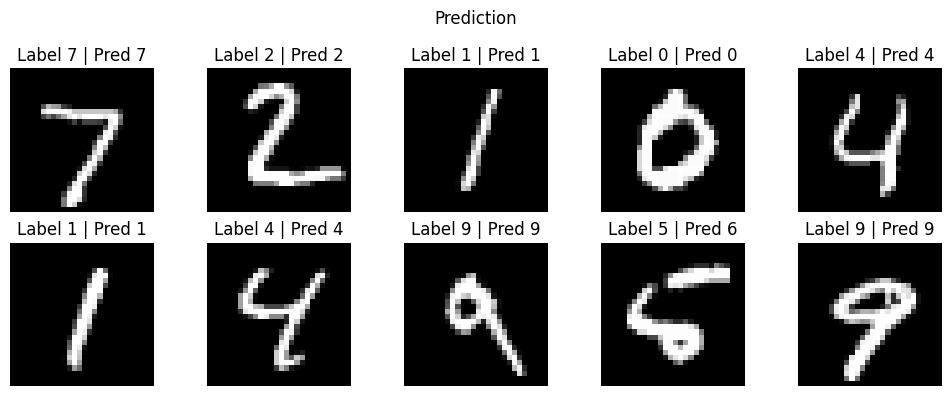

In [382]:
# 仅测试
# 注：必须选择和训练时一样的激活函数，否则准确率极低 !!!
if mode == 'test':
    load(model_load_path, model)
    accuracy = predict(model, test_data)
    print(f'Test result: accuracy = {(accuracy * 100):.2f}%')
    visualize_result(model, test_data)


In [383]:
# 训练 & 测试
if mode == 'both':
    loss_list, acc_list = train(model, train_data, val_data, 
                            epochs, learning_rate, optimizer, 
                            patience, model_save_path, num_class)
    accuracy = predict(model, test_data)
    print(f'Test result: accuracy = {(accuracy * 100):.2f}%')
    plot_loss_acc(loss_list, acc_list)
    visualize_result(model, test_data)
